In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import scipy.io as io
import cv2

import base64
import os
from io import BytesIO
from PIL import Image

from tools.hsi_to_rgb import hsi_to_rgb

In [2]:
"""
This script serves to build the panchromatic (PAN) + hyperspectral (HS) stack with different parameters
by aligning the PAN image to the HS one
"""

'\nThis script serves to build the panchromatic (PAN) + hyperspectral (HS) stack with different parameters\nby aligning the PAN image to the HS one\n'

In [3]:
# Custom Functions

# Normalize the HS across band, NOT every band separately
def np_normalize(array):
    return (array-np.min(array)) /(np.max(array) - np.min(array))

# Find the largest possible rectangle without nan values
def largest_valid_rectangle(mask):
    h, w = mask.shape
    max_area = 0
    max_rect = (0, 0, 0, 0)  # (top, left, height, width)
    dp = [0] * w
    for i in range(h):
        for j in range(w):
            dp[j] = dp[j] + 1 if mask[i][j] else 0

        # Now apply Largest Rectangle in Histogram (LRH) for this row
        stack = []
        for j in range(w + 1):
            height = dp[j] if j < w else 0
            start = j
            while stack and stack[-1][1] > height:
                prev_start, prev_height = stack.pop()
                area = prev_height * (j - prev_start)
                if area > max_area:
                    max_area = area
                    max_rect = (i - prev_height + 1, prev_start, prev_height, j - prev_start)
                start = prev_start
            stack.append((start, height))
    return max_rect


# Select the areas from the hyperspectral and high res RGB photos

In [4]:
# "C:\Users\frcar\Desktop\Git Projects\Aviva analysis\Aviva - spatial fusion - HSI datasets collected with IRIS BRUKER\XGLAB_VISdatacube_AVIVA_complete_1mm.mat" #! entire image, 1156 wavelengths
# "C:\Users\frcar\Desktop\Git Projects\Aviva analysis\Aviva - spatial fusion - HSI datasets collected with IRIS BRUKER\XGLAB_VISdatacube_Avivaface_03mm.mat" #! focus on face, higher res
matfile = io.loadmat(r"Photos/XGLAB_VISdatacube_AvivaFace_03mm.mat")
print(matfile.keys())


dict_keys(['__header__', '__version__', '__globals__', 'WL', 'data'])


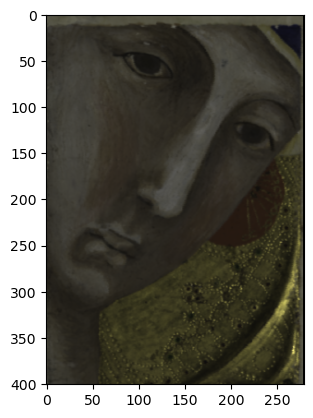

In [5]:
wl_cal = matfile["WL"].squeeze()
hsi_rgb = hsi_to_rgb(matfile["data"],wl_cal)
hsi_rgb = np.rot90(hsi_rgb, k=1)
fig,ax = plt.subplots(1)
ax.imshow(hsi_rgb)

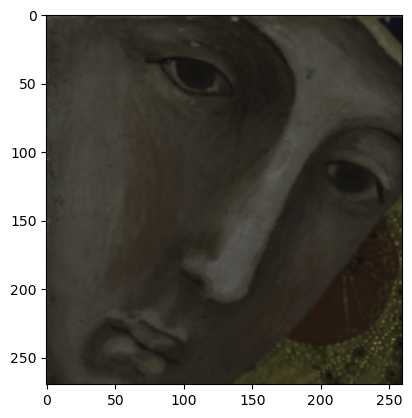

In [6]:
# hsi_target = hsi_rgb[220:300, 200:270]
hsi_target = hsi_rgb[10:280, 0:260]
# target = np.rot90(target, k=1)
fig, axs = plt.subplots()
axs.imshow(hsi_target)

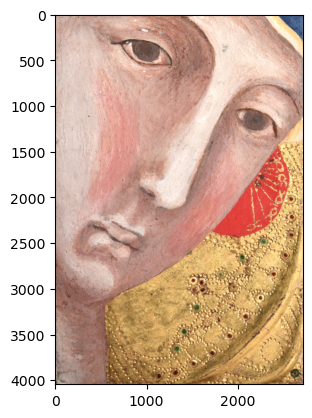

In [7]:
hires_rgb = np.array(Image.open("Photos/Cropped_PAN_ W2710_H4045.jpg"))
fig, axs = plt.subplots()
axs.imshow(hires_rgb)

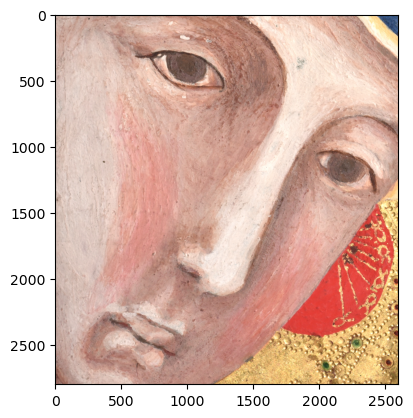

In [8]:
# hr_target = hires_rgb[2100:2900, 1900:3000]
hr_target = hires_rgb[0:2800, 0:2600]
fig, axs = plt.subplots()
axs.imshow(hr_target)

# Now build the stack

(2800, 2600)
(270, 260)


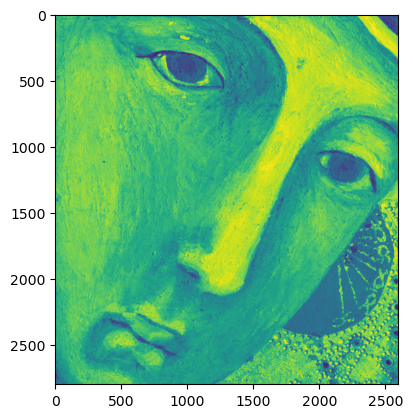

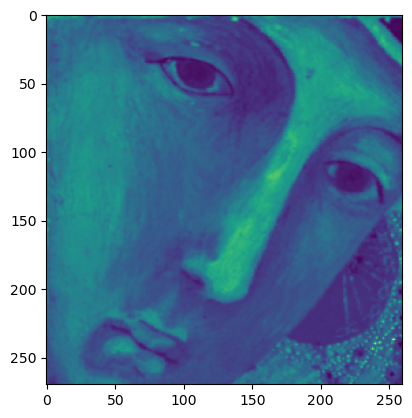

In [9]:
pan = cv2.cvtColor(hr_target, cv2.COLOR_RGB2GRAY)
lr = cv2.cvtColor(hsi_target, cv2.COLOR_RGB2GRAY)

fig, ax = plt.subplots()
ax.imshow(pan)
print(pan.shape)

fig_lr, ax_lr = plt.subplots()
ax_lr.imshow(lr)
print(lr.shape)

Set the ratio

In [10]:
ratio = 6

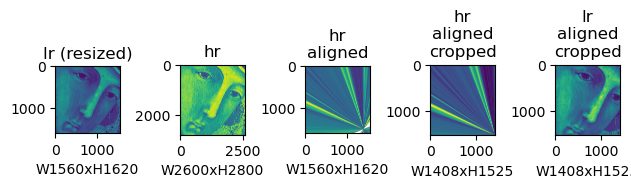

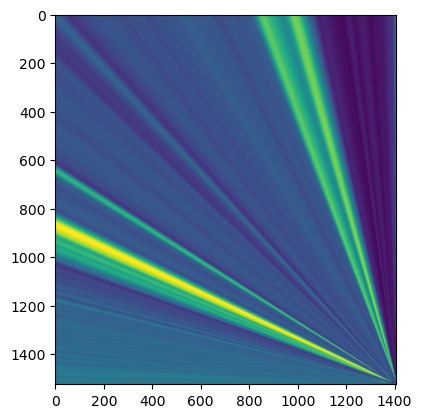

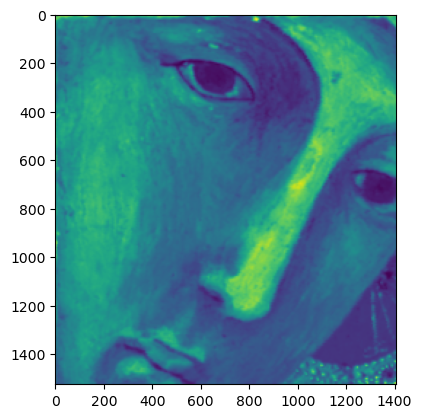

In [11]:
# Align pan to lr
hr = pan

# Normalize and convert to uint8
# lr = np.sum(ms,2) # grayscale lr image, float32
lr = cv2.normalize(lr, None, 0, 255, cv2.NORM_MINMAX)
lr = lr.astype(np.uint8)

hr = cv2.normalize(hr, None, 0, 255, cv2.NORM_MINMAX)
hr = hr.astype(np.uint8)

# Resize low-res to desired res size with NEAREST (could be CUBIC?)
# lr_resized = cv2.resize(lr, (hr.shape[1], hr.shape[0]), interpolation=cv2.INTER_NEAREST) #interpolation=cv2.INTER_CUBIC
lr_resized = cv2.resize(lr, (ratio * lr.shape[1], ratio*lr.shape[0]), interpolation=cv2.INTER_NEAREST) #interpolation=cv2.INTER_CUBIC


###################
# Detect ORB keypoints and descriptors
orb = cv2.ORB_create(500)
kp1, des1 = orb.detectAndCompute(lr_resized, None)
kp2, des2 = orb.detectAndCompute(hr, None)

# Match descriptors using BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Extract location of good matches
lr_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
hr_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

# Estimate homography (or affine if preferred)from hr to lr space
H, _ = cv2.findHomography(hr_pts, lr_pts, cv2.RANSAC, 5.0)
# invert the homography: align pan to ms
# H_inv = np.linalg.inv(H)

# Warp low-res image to align with high-res image 
# hr_aligned = cv2.warpPerspective(hr, H, (hr.shape[1], hr.shape[0]))
hr_aligned = cv2.warpPerspective(hr, H, (lr_resized.shape[1], lr_resized.shape[0]))


######################

# Create a binary mask of valid pixels (1 where data exists)
mask = np.ones(hr.shape[:2], dtype=np.uint8) * 255

# Warp the mask with the same homography
# warped_mask = cv2.warpPerspective(mask, H, (hr.shape[1], hr.shape[0]))
warped_mask = cv2.warpPerspective(mask, H, (lr_resized.shape[1], lr_resized.shape[0]))
warped_mask = warped_mask.astype(bool)

# Convert aligned image to float for NaN assignment
hr_aligned = hr_aligned.astype(np.float32)

# Set pixels with no source (warped_mask is False) to NaN
hr_aligned[~warped_mask] = np.nan

# find the largest possible rectangle (pixels with both lr_resized and hr data)
top, left, height, width = largest_valid_rectangle(warped_mask)
hr_aligned_cropped = hr_aligned[top:top+height, left:left+width]

lr_aligned_cropped = lr_resized[top:top+height, left:left+width]




# Visualize the results
fig, ax = plt.subplots(1,5)
ax[0].imshow(lr_resized)
ax[0].set_title("lr (resized)")
ax[0].set_xlabel(f"W{lr_resized.shape[1]}xH{lr_resized.shape[0]}")
ax[1].imshow(hr)
ax[1].set_title("hr")
ax[1].set_xlabel(f"W{hr.shape[1]}xH{hr.shape[0]}")
ax[2].imshow(hr_aligned)
ax[2].set_title("hr\naligned")
ax[2].set_xlabel(f"W{hr_aligned.shape[1]}xH{hr_aligned.shape[0]}")
ax[3].imshow(hr_aligned_cropped)
ax[3].set_title("hr\naligned\ncropped")
ax[3].set_xlabel(f"W{hr_aligned_cropped.shape[1]}xH{hr_aligned_cropped.shape[0]}")
ax[4].imshow(lr_aligned_cropped)
ax[4].set_title("lr\naligned\ncropped")
ax[4].set_xlabel(f"W{lr_aligned_cropped.shape[1]}xH{lr_aligned_cropped.shape[0]}")
plt.tight_layout()

fig1, ax1 = plt.subplots()
ax1.imshow(hr_aligned_cropped)

fig2, ax2 = plt.subplots()
ax2.imshow(lr_aligned_cropped)

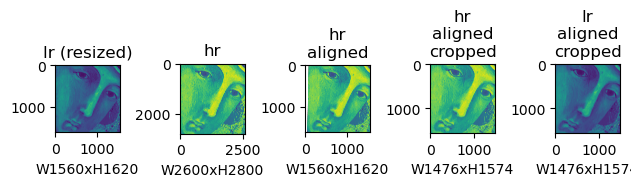

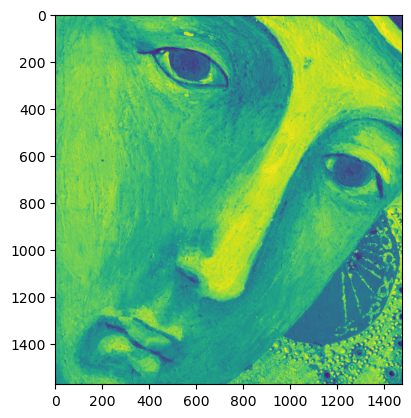

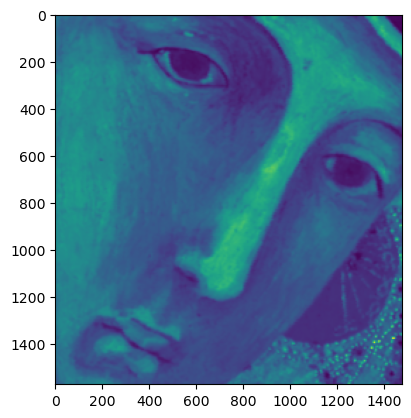

In [12]:
# Use SIFT instead of ORB
# Normalize and convert to uint8
lr = cv2.normalize(lr, None, 0, 255, cv2.NORM_MINMAX)
lr = lr.astype(np.uint8)

hr = cv2.normalize(hr, None, 0, 255, cv2.NORM_MINMAX)
hr = hr.astype(np.uint8)

lr_resized = cv2.resize(lr, (ratio * lr.shape[1], ratio*lr.shape[0]), interpolation=cv2.INTER_NEAREST) #interpolation=cv2.INTER_CUBIC


sift = cv2.SIFT_create(nfeatures=500)  # OR cv2.xfeatures2d.SIFT_create()

# Detect keypoints + descriptors
kp1, des1 = sift.detectAndCompute(lr_resized, None)
kp2, des2 = sift.detectAndCompute(hr, None)

# Match with KNN matcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extract matched points
lr_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
hr_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Estimate affine instead of homography
M, _ = cv2.estimateAffinePartial2D(hr_pts, lr_pts, method=cv2.RANSAC)

# Warp image
hr_aligned = cv2.warpAffine(hr, M, (lr_resized.shape[1], lr_resized.shape[0]))


# Create a binary mask of valid pixels (1 where data exists)
mask = np.ones(hr.shape[:2], dtype=np.uint8) * 255

# Warp the mask with the same homography
# warped_mask = cv2.warpPerspective(mask, H, (hr.shape[1], hr.shape[0]))
warped_mask = cv2.warpAffine(mask, M, (lr_resized.shape[1], lr_resized.shape[0]))
warped_mask = warped_mask.astype(bool)

# Convert aligned image to float for NaN assignment
hr_aligned = hr_aligned.astype(np.float32)

# Set pixels with no source (warped_mask is False) to NaN
hr_aligned[~warped_mask] = np.nan

# find the largest possible rectangle (pixels with both lr_resized and hr data)
top, left, height, width = largest_valid_rectangle(warped_mask)
hr_aligned_cropped = hr_aligned[top:top+height, left:left+width]

lr_aligned_cropped = lr_resized[top:top+height, left:left+width]




# Visualize the results
fig, ax = plt.subplots(1,5)
ax[0].imshow(lr_resized)
ax[0].set_title("lr (resized)")
ax[0].set_xlabel(f"W{lr_resized.shape[1]}xH{lr_resized.shape[0]}")
ax[1].imshow(hr)
ax[1].set_title("hr")
ax[1].set_xlabel(f"W{hr.shape[1]}xH{hr.shape[0]}")
ax[2].imshow(hr_aligned)
ax[2].set_title("hr\naligned")
ax[2].set_xlabel(f"W{hr_aligned.shape[1]}xH{hr_aligned.shape[0]}")
ax[3].imshow(hr_aligned_cropped)
ax[3].set_title("hr\naligned\ncropped")
ax[3].set_xlabel(f"W{hr_aligned_cropped.shape[1]}xH{hr_aligned_cropped.shape[0]}")
ax[4].imshow(lr_aligned_cropped)
ax[4].set_title("lr\naligned\ncropped")
ax[4].set_xlabel(f"W{lr_aligned_cropped.shape[1]}xH{lr_aligned_cropped.shape[0]}")
plt.tight_layout()

fig1, ax1 = plt.subplots()
ax1.imshow(hr_aligned_cropped)

fig2, ax2 = plt.subplots()
ax2.imshow(lr_aligned_cropped)


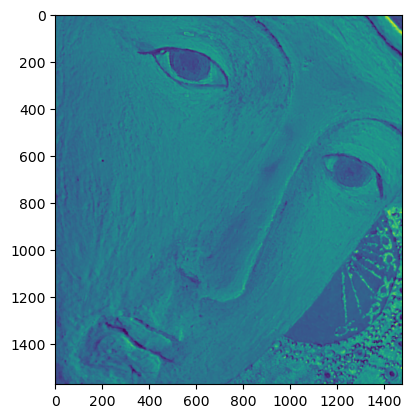

In [13]:
# calculate the error between the resized low res and a blurred high res
err = np.abs(cv2.blur(hr_aligned_cropped, (ratio, ratio)) - lr_aligned_cropped)
figerr, axerr = plt.subplots()
axerr.imshow(err)

Apply the transformation to another part of the image

ORB + WarpPerspective

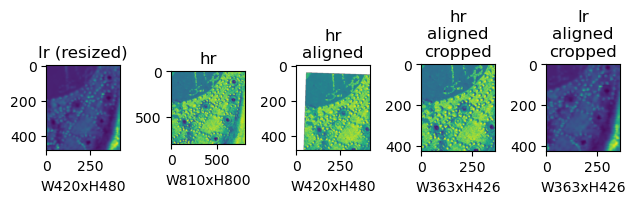

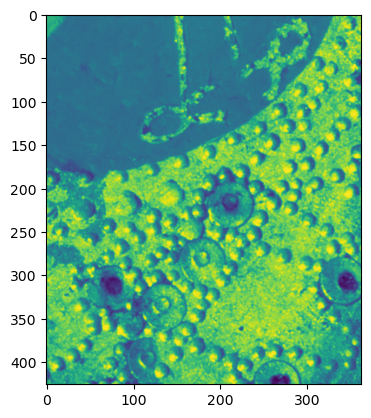

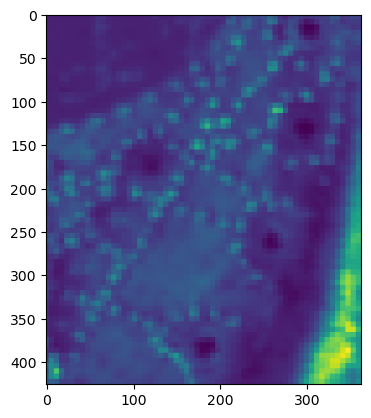

In [ ]:
hsi_target = hsi_rgb[220:300, 200:270]
hr_target = hires_rgb[2100:2900, 1900:3000]

hr = cv2.cvtColor(hr_target, cv2.COLOR_RGB2GRAY)
lr = cv2.cvtColor(hsi_target, cv2.COLOR_RGB2GRAY)
lr_resized = cv2.resize(lr, (ratio * lr.shape[1], ratio*lr.shape[0]), interpolation=cv2.INTER_NEAREST) #interpolation=cv2.INTER_CUBIC


# Warp low-res image to align with high-res image 
# hr_aligned = cv2.warpPerspective(hr, H, (hr.shape[1], hr.shape[0]))
hr_aligned = cv2.warpAffine(hr, M, (lr_resized.shape[1], lr_resized.shape[0]))


# Create a binary mask of valid pixels (1 where data exists)
mask = np.ones(hr.shape[:2], dtype=np.uint8) * 255

# Warp the mask with the same homography
# warped_mask = cv2.warpPerspective(mask, H, (hr.shape[1], hr.shape[0]))
warped_mask = cv2.warpAffine(mask, M, (lr_resized.shape[1], lr_resized.shape[0]))
warped_mask = warped_mask.astype(bool)

# Convert aligned image to float for NaN assignment
hr_aligned = hr_aligned.astype(np.float32)

# Set pixels with no source (warped_mask is False) to NaN
hr_aligned[~warped_mask] = np.nan

# find the largest possible rectangle (pixels with both lr_resized and hr data)
top, left, height, width = largest_valid_rectangle(warped_mask)
hr_aligned_cropped = hr_aligned[top:top+height, left:left+width]

lr_aligned_cropped = lr_resized[top:top+height, left:left+width]




# Visualize the results
fig, ax = plt.subplots(1,5)
ax[0].imshow(lr_resized)
ax[0].set_title("lr (resized)")
ax[0].set_xlabel(f"W{lr_resized.shape[1]}xH{lr_resized.shape[0]}")
ax[1].imshow(hr)
ax[1].set_title("hr")
ax[1].set_xlabel(f"W{hr.shape[1]}xH{hr.shape[0]}")
ax[2].imshow(hr_aligned)
ax[2].set_title("hr\naligned")
ax[2].set_xlabel(f"W{hr_aligned.shape[1]}xH{hr_aligned.shape[0]}")
ax[3].imshow(hr_aligned_cropped)
ax[3].set_title("hr\naligned\ncropped")
ax[3].set_xlabel(f"W{hr_aligned_cropped.shape[1]}xH{hr_aligned_cropped.shape[0]}")
ax[4].imshow(lr_aligned_cropped)
ax[4].set_title("lr\naligned\ncropped")
ax[4].set_xlabel(f"W{lr_aligned_cropped.shape[1]}xH{lr_aligned_cropped.shape[0]}")
plt.tight_layout()

fig1, ax1 = plt.subplots()
ax1.imshow(hr_aligned_cropped)

fig2, ax2 = plt.subplots()
ax2.imshow(lr_aligned_cropped)

SiFT + WarpAffine

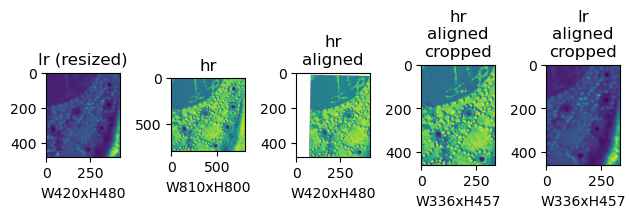

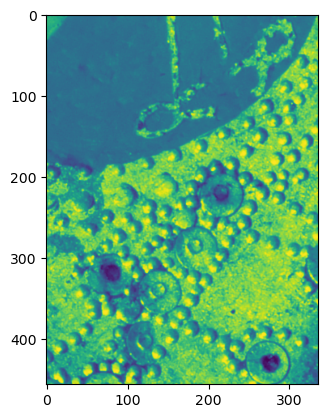

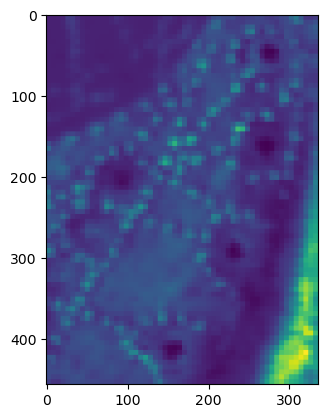

In [ ]:
hsi_target = hsi_rgb[220:300, 200:270]
hr_target = hires_rgb[2100:2900, 1900:3000]

hr = cv2.cvtColor(hr_target, cv2.COLOR_RGB2GRAY)
lr = cv2.cvtColor(hsi_target, cv2.COLOR_RGB2GRAY)
lr_resized = cv2.resize(lr, (ratio * lr.shape[1], ratio*lr.shape[0]), interpolation=cv2.INTER_NEAREST) #interpolation=cv2.INTER_CUBIC


# Warp low-res image to align with high-res image 
# hr_aligned = cv2.warpPerspective(hr, H, (hr.shape[1], hr.shape[0]))
hr_aligned = cv2.warpAffine(hr, M, (lr_resized.shape[1], lr_resized.shape[0]))


######################

# Create a binary mask of valid pixels (1 where data exists)
mask = np.ones(hr.shape[:2], dtype=np.uint8) * 255

# Warp the mask with the same homography
# warped_mask = cv2.warpPerspective(mask, H, (hr.shape[1], hr.shape[0]))
warped_mask = cv2.warpAffine(mask, M, (lr_resized.shape[1], lr_resized.shape[0]))
warped_mask = warped_mask.astype(bool)

# Convert aligned image to float for NaN assignment
hr_aligned = hr_aligned.astype(np.float32)

# Set pixels with no source (warped_mask is False) to NaN
hr_aligned[~warped_mask] = np.nan

# find the largest possible rectangle (pixels with both lr_resized and hr data)
top, left, height, width = largest_valid_rectangle(warped_mask)
hr_aligned_cropped = hr_aligned[top:top+height, left:left+width]

lr_aligned_cropped = lr_resized[top:top+height, left:left+width]




# Visualize the results
fig, ax = plt.subplots(1,5)
ax[0].imshow(lr_resized)
ax[0].set_title("lr (resized)")
ax[0].set_xlabel(f"W{lr_resized.shape[1]}xH{lr_resized.shape[0]}")
ax[1].imshow(hr)
ax[1].set_title("hr")
ax[1].set_xlabel(f"W{hr.shape[1]}xH{hr.shape[0]}")
ax[2].imshow(hr_aligned)
ax[2].set_title("hr\naligned")
ax[2].set_xlabel(f"W{hr_aligned.shape[1]}xH{hr_aligned.shape[0]}")
ax[3].imshow(hr_aligned_cropped)
ax[3].set_title("hr\naligned\ncropped")
ax[3].set_xlabel(f"W{hr_aligned_cropped.shape[1]}xH{hr_aligned_cropped.shape[0]}")
ax[4].imshow(lr_aligned_cropped)
ax[4].set_title("lr\naligned\ncropped")
ax[4].set_xlabel(f"W{lr_aligned_cropped.shape[1]}xH{lr_aligned_cropped.shape[0]}")
plt.tight_layout()

fig1, ax1 = plt.subplots()
ax1.imshow(hr_aligned_cropped)

fig2, ax2 = plt.subplots()
ax2.imshow(lr_aligned_cropped)

When happy with the results, crate the stack

In [14]:
hyperspectral_image = np.rot90(matfile["data"], k = 1)
hs = hyperspectral_image[10:280, 0:260]

hs = hs[:,:,::100]
# stack will have the height and width of the largest rectangle found with the appropriate function 
stack = np.zeros((height, width, hs.shape[2]+1)) # as many bands as original HS +1 for PAN
for i in range(hs.shape[2]): # for every band/wavelength
    hs_up = cv2.resize(hs[:,:,i], (ratio*hs.shape[1], ratio*hs.shape[0]), interpolation=cv2.INTER_NEAREST)
    stack[:,:,i] = (hs_up[top:top+height, left:left+width])  # select only the rectangle 
stack[:,:,:-1] = np_normalize(stack[:,:,:-1])
stack[:,:,-1] = np_normalize(hr_aligned_cropped.astype("float32")) # the last layer is the aligned and cropped pan

# ground truth
gt = np_normalize(stack[::ratio,::ratio,:-1]) # <- these are the exact pixels surviving the masking, except the last layer, which is the pan


In [15]:
# save relevant variables in mat file
wl_cal = wl_cal[::100]
mat_dict = {
    "I_MS": stack[:, :, :-1],
    "I_MS_LR": gt[:, :, :],
    "I_PAN": stack[:, :, -1],
    "Wavelengths": wl_cal
}

title = "aviva_face_aligned_r6_rwl.mat"
savepath = os.path.join("Datasets", title)
print(savepath)


Datasets/aviva_face_aligned_r6_rwl.mat


In [16]:
savemat(savepath, mat_dict)

# END of code

In [24]:
# load simple examples
tmp = io.loadmat(r"Aviva_eye_test_r2.mat")
print(tmp.keys())


dict_keys(['__header__', '__version__', '__globals__', 'I_MS_LR', 'I_PAN', 'WL'])


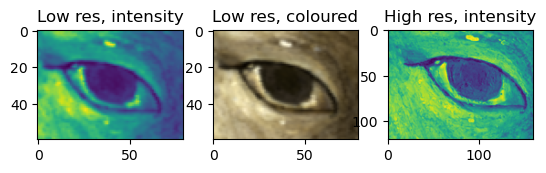

In [ ]:

ms = tmp["I_MS_LR"].astype("float32")
ms = np_normalize(ms)

wl_cal = np.squeeze(tmp["WL"].astype("float32"))

pan = tmp["I_PAN"].astype("float32")
pan = np_normalize(pan)

# color the ms image
rgb = hsi_to_rgb.hsi_to_rgb(ms, wl_cal)

fig, ax = plt.subplots(1,3)
ax[0].imshow(np.sum(ms,2))
ax[0].set_title("Low res, intensity");
ax[1].imshow(rgb)
ax[1].set_title("Low res, coloured");
ax[2].imshow(pan)
ax[2].set_title("High res, intensity");


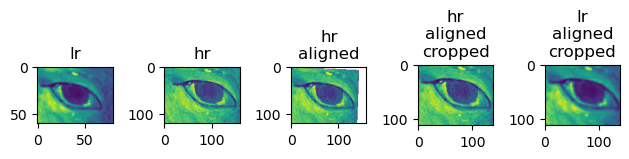

In [ ]:
# Align lr to pan
ratio = 2
hr = pan

# Normalize and convert to uint8
lr = np.sum(ms,2) # grayscale lr image, float32
lr = cv2.normalize(lr, None, 0, 255, cv2.NORM_MINMAX)
lr = lr.astype(np.uint8)

hr = cv2.normalize(hr, None, 0, 255, cv2.NORM_MINMAX)
hr = hr.astype(np.uint8)

# Resize low-res to high-res size with NEAREST (could be CUBIC?)
lr_resized = cv2.resize(lr, (hr.shape[1], hr.shape[0]), interpolation=cv2.INTER_NEAREST) #interpolation=cv2.INTER_CUBIC

###################
# Detect ORB keypoints and descriptors
orb = cv2.ORB_create(500)
kp1, des1 = orb.detectAndCompute(lr_resized, None)
kp2, des2 = orb.detectAndCompute(hr, None)

# Match descriptors using BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Extract location of good matches
lr_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
hr_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

# Estimate homography (or affine if preferred)from hr to lr space
H, _ = cv2.findHomography(hr_pts, lr_pts, cv2.RANSAC, 5.0)
# invert the homography: align pan to ms
# H_inv = np.linalg.inv(H)

# Warp low-res image to align with high-res image 
hr_aligned = cv2.warpPerspective(hr, H, (hr.shape[1], hr.shape[0]))

######################

# Create a binary mask of valid pixels (1 where data exists)
mask = np.ones(hr.shape[:2], dtype=np.uint8) * 255

# Warp the mask with the same homography
warped_mask = cv2.warpPerspective(mask, H, (hr.shape[1], hr.shape[0]))
warped_mask = warped_mask.astype(bool)

# Convert aligned image to float for NaN assignment
hr_aligned = hr_aligned.astype(np.float32)

# Set pixels with no source (warped_mask is False) to NaN
hr_aligned[~warped_mask] = np.nan

# find the largest possible rectangle (pixels with both lr_resized and hr data)
top, left, height, width = largest_valid_rectangle(warped_mask)
hr_aligned_cropped = hr_aligned[top:top+height, left:left+width]

lr_aligned_cropped = lr_resized[top:top+height, left:left+width]




# Visualize the results
fig, ax = plt.subplots(1,5)
ax[0].imshow(lr)
ax[0].set_title("lr")
ax[1].imshow(hr)
ax[1].set_title("hr")
ax[2].imshow(hr_aligned)
ax[2].set_title("hr\naligned")
ax[3].imshow(hr_aligned_cropped)
ax[3].set_title("hr\naligned\ncropped")
ax[4].imshow(lr_aligned_cropped)
ax[4].set_title("lr\naligned\ncropped")
plt.tight_layout()


In [ ]:
# Now transform all the bands in the HS image and build the stack

# stack will have the height and width of the largest rectangle found with the appropriate function 
stack = np.zeros((height, width, ms.shape[2]+1)) # as many bands as original HS +1 for PAN
for i in range(ms.shape[2]): # for every band/wavelength
    ms_up = cv2.resize(ms[:,:,i], (pan.shape[1], pan.shape[0]), interpolation=cv2.INTER_NEAREST)
    stack[:,:,i] = (ms_up[top:top+height, left:left+width])  # select only the rectangle 
stack[:,:,:-1] = np_normalize(stack[:,:,:-1])
stack[:,:,-1] = np_normalize(hr_aligned_cropped.astype("float32")) # the last layer is the aligned and cropped pan

# ground truth
gt = np_normalize(stack[::ratio,::ratio,:-1]) # <- these are the exact pixels surviving the masking, except the last layer, which is the pan


In [ ]:
# save relevant variables in mat file

I_MS = stack[:, :, :-1]
I_MS_LR = gt[:, :, :]
I_PAN = stack[:, :, -1]
Wavelengths = wl_cal

mat_dict = {
    "I_MS": I_MS,
    "I_MS_LR": I_MS_LR,
    "I_PAN": I_PAN,
    "Wavelengths": Wavelengths
}

title = "aviva_eye_aligned_r2_v2.mat"
savepath = os.path.join("Datasets", title)
print(savepath)


In [ ]:
io.savemat(savepath, mat_dict)